## Cluster Analysis

This script imports the filtered data and runs cluster analysis
filtered_data.csv: rows where userIDs have <3 entries are removed

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [3]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2OGeneralizedLowRankEstimator
from h2o.estimators import H2OKMeansEstimator
import warnings

## Import Endo Data

In [5]:
# Read in filtered data
h2o.init()
file_path = 'data/agg_data.csv'
data = h2o.import_file(file_path)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_421"; Java(TM) SE Runtime Environment (build 1.8.0_421-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from /Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpz6arvlln
  JVM stdout: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpz6arvlln/h2o_michelle_started_from_python.out
  JVM stderr: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpz6arvlln/h2o_michelle_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/Dublin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_michelle_d6zp0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.540 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
print("Null values:", data.isna().sum())
data.shape

Null values: 0.0


(1918, 35)

In [7]:
# Convert columns to categorical 
categorical_columns = ['period', 'sex', 'period_intensity', 'pain_level','backaches', 
                'bodyaches', 'stomach_cramps', 'joint_pains', 'tender_breasts', 'overall_pain', 'headache',
                'indigestion', 'bloating','constipation', 'diarrhea', 'nausea', 'vomiting', 'appetite_loss', 
                'cravings_salty', 'cravings_sweet', 'skin_changes', 'acne', 'tiredness', 'dizziness',
                'pins_and_needles', 'temperature', 'fever', 'hot_flashes', 'short_of_breath', 'coughing', 
                'insomnia', 'work_affected']

for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].asfactor()

data.types

{'period': 'enum',
 'sex': 'enum',
 'period_intensity': 'enum',
 'pain_level': 'enum',
 'backaches': 'enum',
 'bodyaches': 'enum',
 'stomach_cramps': 'enum',
 'joint_pains': 'enum',
 'tender_breasts': 'enum',
 'overall_pain': 'enum',
 'headache': 'enum',
 'indigestion': 'enum',
 'bloating': 'enum',
 'constipation': 'enum',
 'diarrhea': 'enum',
 'nausea': 'enum',
 'vomiting': 'enum',
 'appetite_loss': 'enum',
 'cravings_salty': 'enum',
 'cravings_sweet': 'enum',
 'skin_changes': 'enum',
 'acne': 'enum',
 'tiredness': 'enum',
 'dizziness': 'enum',
 'pins_and_needles': 'enum',
 'temperature': 'enum',
 'fever': 'enum',
 'hot_flashes': 'enum',
 'short_of_breath': 'enum',
 'coughing': 'enum',
 'insomnia': 'enum',
 'work_affected': 'enum',
 'weight': 'real',
 'sleep': 'real',
 'log_steps': 'real'}

In [8]:
# Specify the data type for each column
loss_by_col = ['Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic']

# GLRM Model

#### Generalized Low Rank Model

In [11]:
# Build and train the model
glrm_model = H2OGeneralizedLowRankEstimator(
    k=18,
    loss_by_col=loss_by_col,
    transform="standardize",
    seed=1234
)

# Train model
glrm_model.train(training_frame=data)

glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLowRankEstimator : Generalized Low Rank Modeling
Model Key: GLRM_model_python_1725116530442_1


Model Summary: 
    number_of_iterations    final_step_size    final_objective_value
--  ----------------------  -----------------  -----------------------
    1000                    0.00245863         49332.6

ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 1248.1553601173487
Misclassification Error (Categorical): 11195.0

Scoring History: 
     timestamp            duration          iterations    step_size              objective
---  -------------------  ----------------  ------------  ---------------------  ------------------
     2024-08-31 16:02:30  3.953 sec         0.0           0.6666666666666666     271538.7817128262
     2024-08-31 16:02:31  4.660 sec         1.0           0.4444444444444444     271538.7817128262
     2024-08-31 16:02:31  4.766 sec         2.0           0.2222222222222222     271538.7817128262
     2024-08-31 16:02:31  4.908 sec         3.0           0.23333333333333334    189428.21087432042
     2024-08-31 16:02:31  5.029 sec         4.0           0.15555555555555556    189428.21087432042
     2024-08-31 16:02:31  5.311 sec         5.0           0.16333333333333333    129787.19020974428
     2024-08-31 16:02:31  5.478 sec         6.0           0.10888888888888888    129787.19020974428
     2024-08-31 16:02:32  5.637 sec         7.0           0.11433333333333333    129620.65419686951
     2024-08-31 16:02:32  5.747 sec         8.0           0.07622222222222222    129620.65419686951
     2024-08-31 16:02:32  5.921 sec         9.0           0.05081481481481481    129620.65419686951
---  ---                  ---               ---           ---                    ---
     2024-08-31 16:03:27  1 min  1.248 sec  990.0         0.0024961473854045904  49347.63563711637
     2024-08-31 16:03:27  1 min  1.293 sec  991.0         0.00262095475467482    49347.40266156306
     2024-08-31 16:03:27  1 min  1.339 sec  992.0         0.0027520024924085613  49347.015749411585
     2024-08-31 16:03:27  1 min  1.378 sec  993.0         0.0028896026170289893  49346.95220069232
     2024-08-31 16:03:27  1 min  1.416 sec  994.0         0.003034082747880439   49346.26972790841
     2024-08-31 16:03:27  1 min  1.463 sec  995.0         0.0031857868852744613  49346.01557167694
     2024-08-31 16:03:27  1 min  1.508 sec  996.0         0.0021238579235163075  49346.01557167694
     2024-08-31 16:03:28  1 min  1.550 sec  997.0         0.002230050819692123   49335.84603997357
     2024-08-31 16:03:28  1 min  1.592 sec  998.0         0.0023415533606767295  49332.7095737076
     2024-08-31 16:03:28  1 min  1.640 sec  999.0         0.0024586310287105662  49332.576466464016
[1000 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [12]:
# Extract the low-rank representation (X)
X = glrm_model._model_json['output']['representation_name']
A_low_rank_rep = h2o.get_frame(X)

# Transform the valid  data to retrieve the new coefficients:
B_glrm_data = glrm_model.transform_frame(data)

In [13]:
A_low_rank_rep.isna().sum()

0.0

# K-means

In [15]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)

# Eval performance:
perf = kmeans_model.model_performance()
print(perf)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 3233.9983182726173
Total Sum of Square Error to Grand Mean: 3960.32659654344
Between Cluster Sum of Square Error: 726.3282782708225

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           220     505.919
    2           753     1037.39
    3           634     1064.6
    4           311     626.084


In [16]:
# Assess k for a range of values
range_clusters = range(2, 8)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

for n in range_clusters:

    kmeans_model = H2OKMeansEstimator(k=n,
                                 standardize=False,
                                 seed=1234)

    kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)
    
    cluster_assignments = kmeans_model.predict(B_glrm_data)
    
    # Convert to pandas DataFrame for silhouette score calculation
    cluster_assignments_df = cluster_assignments.as_data_frame()
    data_df = B_glrm_data.as_data_frame()
    
    # Add cluster assignments to the original data
    data_df['cluster'] = cluster_assignments_df['predict'].astype(int)

    # Calculate WCSS (total within-cluster sum of squares)
    wcss.append(kmeans_model.tot_withinss())
    print(f"Number of clusters: {n}, WCSS: {wcss}")
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_df.drop('cluster', axis=1), data_df['cluster'])
    silhouette_scores.append(sil_score)
    print(f"Number of clusters: {n}, Silhouette Score: {sil_score:.3f}")


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 2, WCSS: [3552.496419275614]
Number of clusters: 2, Silhouette Score: 0.104
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 3, WCSS: [3552.496419275614, 3412.8033765621167]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 3, Silhouette Score: 0.051
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 4, WCSS: [3552.496419275614, 3412.8033765621167, 3251.2679396166095]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 4, Silhouette Score: 0.052
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 5, WCSS: [3552.496419275614, 3412.8033765621167, 3251.2679396166095, 3129.1629731699854]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 5, Silhouette Score: 0.054
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 6, WCSS: [3552.496419275614, 3412.8033765621167, 3251.2679396166095, 3129.1629731699854, 3082.3149835997333]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 6, Silhouette Score: 0.043
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 7, WCSS: [3552.496419275614, 3412.8033765621167, 3251.2679396166095, 3129.1629731699854, 3082.3149835997333, 3003.8162263851186]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 7, Silhouette Score: 0.040


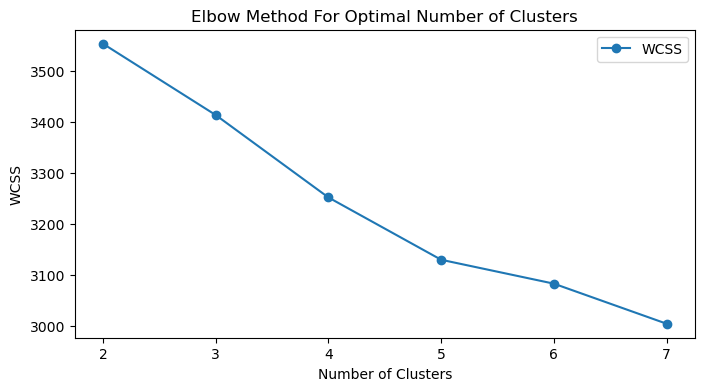

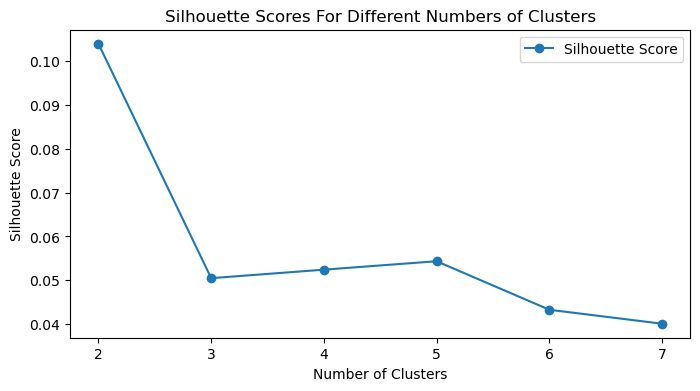

In [17]:
# Plotting the Elbow Method results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, wcss, marker='o', label='WCSS')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

# Plotting the Silhouette Analysis results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Scores For Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()


In [18]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=4,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OKMeansEstimator : K-means
Model Key: KMeans_model_python_1725116530442_10


Model Summary: 
    number_of_rows    number_of_clusters    number_of_categorical_columns    number_of_iterations    within_cluster_sum_of_squares    total_sum_of_squares    between_cluster_sum_of_squares
--  ----------------  --------------------  -------------------------------  ----------------------  -------------------------------  ----------------------  --------------------------------
    1918              4                     0                                32                      3234.07                          3960.33                 726.257

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 3233.9983182726173
Total Sum of Square Error to Grand Mean: 3960.32659654344
Between Cluster Sum of Square Error: 726.3282782708225

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           220     505.919
    2           753     1037.39
    3           634     1064.6
    4           311     626.084

ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 6430.3165162702935
Total Sum of Square Error to Grand Mean: 7566.344569879167
Between Cluster Sum of Square Error: 1136.028053608873

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           247     939.785
    2           781     2682.54
    3           531     1530.93
    4           359     1277.06

Scoring History: 
     timestamp            duration    iterations    number_of_clusters    number_of_reassigned_observations    within_cluster_sum_of_squares
---  -------------------  ----------  ------------  --------------------  -----------------------------------  -------------------------------
     2024-08-31 16:03:47  0.015 sec   0.0           0.0                   nan                                  nan
     2024-08-31 16:03:47  0.075 sec   1.0           1.0                   1918.0                               8923.5770352601
     2024-08-31 16:03:47  0.081 sec   2.0           1.0                   0.0                                  3960.3265970089146
     2024-08-31 16:03:47  0.114 sec   3.0           2.0                   96.0                                 3797.6963051999924
     2024-08-31 16:03:47  0.117 sec   4.0           2.0                   82.0                                 3791.546714054596
     2024-08-31 16:03:47  0.132 sec   5.0           2.0                   96.0                                 3783.9028003087187
     2024-08-31 16:03:47  0.153 sec   6.0           2.0                   145.0                                3766.2355943043935
     2024-08-31 16:03:47  0.171 sec   7.0           2.0                   177.0                                3729.4428499705864
     2024-08-31 16:03:47  0.178 sec   8.0           2.0                   202.0                                3675.002684509689
     2024-08-31 16:03:47  0.185 sec   9.0           2.0                   188.0                                3611.6185839840405
---  ---                  ---         ---           ---                   ---                                  ---
     2024-08-31 16:03:47  0.400 sec   23.0          4.0                   161.0                                3274.9367753737165
     2024-08-31 16:03:47  0.408 sec   24.0          4.0                   84.0                                 3248.7110097120294
     2024-08-31 16:03:47  0.412 sec   25.0          4.0                   50.0                                 3240.948020867487
     2024-08-31 16:03:47  0.420 sec   26.0          4.0                   41.0                                 3237.7690254749014
     2024-08-31 16:03:47  0.424 sec   27.0          4.0                   28.0                                 32

## Predict cluster labels


In [20]:
# Predict cluster labels for the low-rank representation of the data
cluster_labels = kmeans_model.predict(B_glrm_data)
print(cluster_labels.shape)

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
(1918, 1)


In [21]:
# Convert to pandas DataFrame
cluster_labels_df = cluster_labels.as_data_frame()

# Add cluster assignments to the original data
clustered_data = data.as_data_frame()
clustered_data['cluster'] = cluster_labels_df['predict'].astype(int)

# Convert complete data to pandas DataFrame 
data_df = data.as_data_frame()

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster co

In [22]:
# Save cluster labels to drive
cluster_labels_df.to_csv('data/cluster_labels.csv', index=False)

In [23]:
# Shut down h2o session
h2o.cluster().shutdown()

H2O session _sid_b7fb closed.


In [24]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,weight,sleep,log_steps,cluster
0,1,1,4,0,3,2,3,3,3,3,...,1,0,2,2,1,1,85.53192,427.959908,8.954738,3
1,1,1,3,7,1,2,3,2,1,0,...,0,0,0,0,0,1,85.53192,427.959908,8.336683,2
2,1,0,3,9,3,3,3,3,2,3,...,2,3,3,2,3,0,85.53192,427.959908,8.336683,3
3,1,0,1,0,1,2,2,3,1,1,...,1,1,1,1,1,0,85.53192,427.959908,9.364491,0
4,1,1,6,0,1,2,2,2,2,2,...,0,0,1,0,1,1,85.53192,427.959908,8.336683,2


In [25]:
# Add 1 to each cluster number to rename clusters 1-4
clustered_data['cluster'] = clustered_data['cluster'] + 1

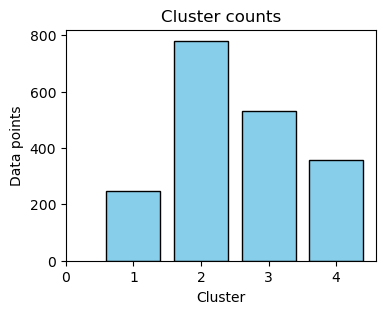

In [26]:
# Bar chart with data in each cluster
cluster, counts = np.unique(clustered_data['cluster'], return_counts=True)
plt.figure(figsize=(4, 3))
plt.bar(cluster, counts, color='skyblue', edgecolor='black')
plt.title('Cluster counts')
plt.xlabel('Cluster')
plt.ylabel('Data points')
plt.xticks(ticks=np.arange(5), labels=np.arange(0, 5))
plt.show()


SIGNIFICANT difference in pain_level levels between the clusters accoring to ANOVA.
                  sum_sq      df         F        PR(>F)
C(cluster)   1656.434592     3.0  35.07727  4.580195e-22
Residual    30127.922550  1914.0       NaN           NaN


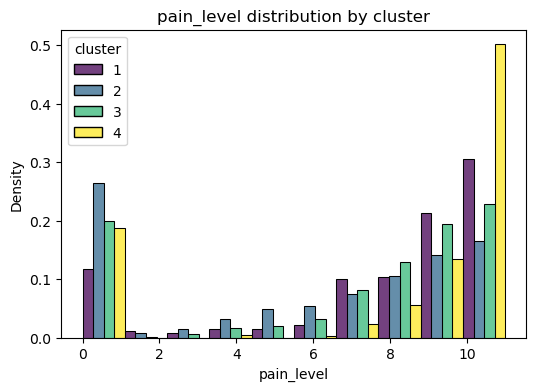


SIGNIFICANT difference in period_intensity levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)   853.756511     3.0  74.437438  1.546319e-45
Residual    7317.509391  1914.0        NaN           NaN


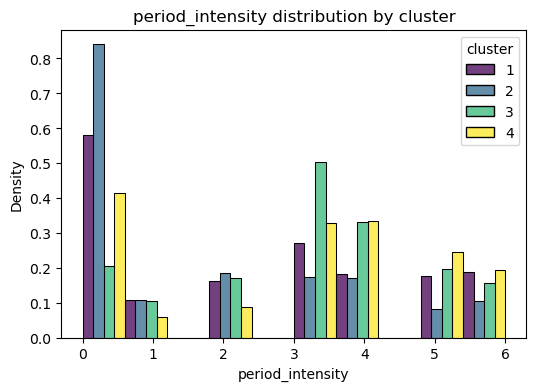


SIGNIFICANT difference in overall_pain levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    45.780623     3.0  15.120722  9.983497e-10
Residual    1931.656291  1914.0        NaN           NaN


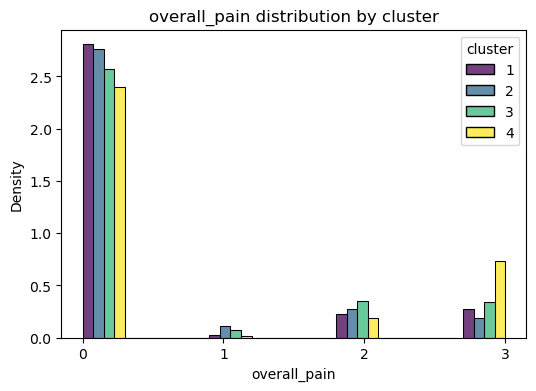


SIGNIFICANT difference in bloating levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   478.695298     3.0  200.921475  2.789624e-113
Residual    1520.034629  1914.0         NaN            NaN


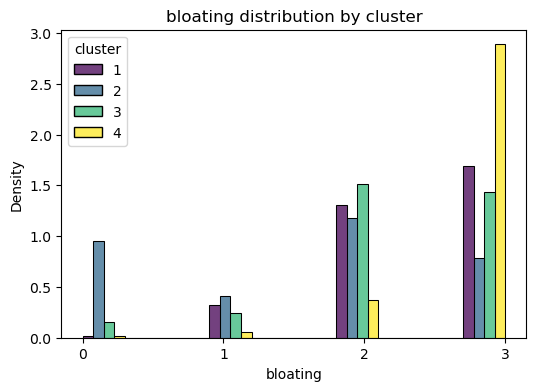


SIGNIFICANT difference in appetite_loss levels between the clusters accoring to ANOVA.
                 sum_sq      df          F         PR(>F)
C(cluster)   783.629584     3.0  279.17316  2.708754e-150
Residual    1790.844347  1914.0        NaN            NaN


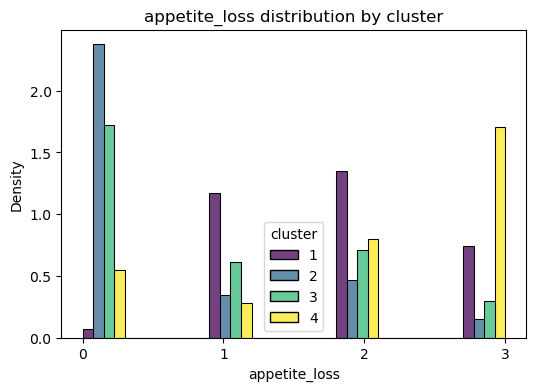


SIGNIFICANT difference in tiredness levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   511.934606     3.0  217.919989  1.322885e-121
Residual    1498.780722  1914.0         NaN            NaN


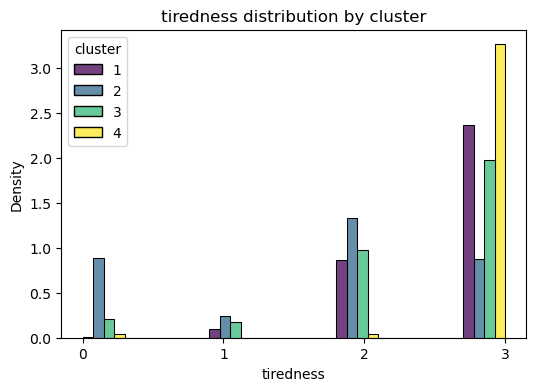


SIGNIFICANT difference in fever levels between the clusters accoring to ANOVA.
                sum_sq      df          F         PR(>F)
C(cluster)  350.781486     3.0  234.85963  9.732374e-130
Residual    952.903603  1914.0        NaN            NaN


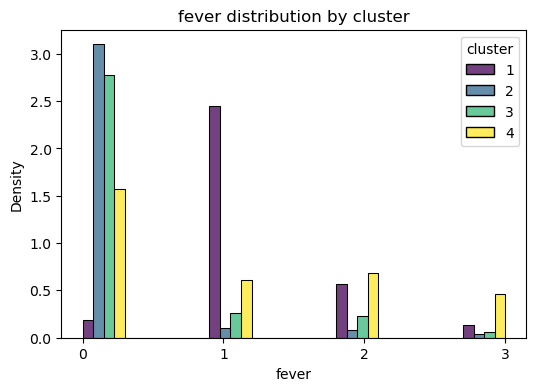


SIGNIFICANT difference in log_steps levels between the clusters accoring to ANOVA.
                sum_sq      df        F    PR(>F)
C(cluster)    4.760237     3.0  6.04831  0.000427
Residual    502.128963  1914.0      NaN       NaN


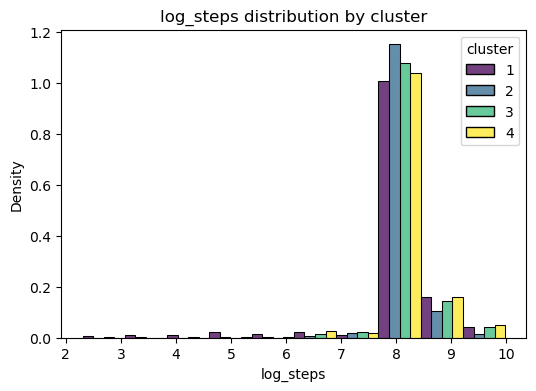


NO significant difference in weight levels between the clusters accoring to ANOVA.
                  sum_sq      df         F   PR(>F)
C(cluster)  9.274786e+02     3.0  0.452961  0.71523
Residual    1.306362e+06  1914.0       NaN      NaN


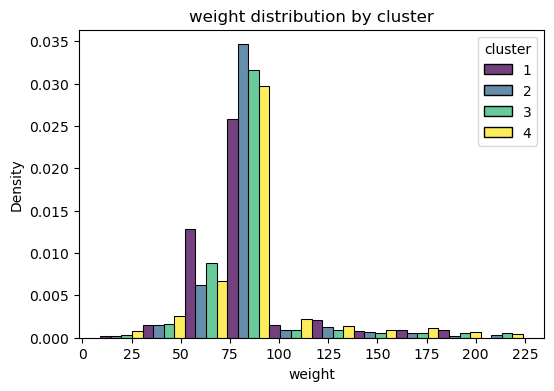


SIGNIFICANT difference in backaches levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   602.650531     3.0  240.538888  1.979317e-132
Residual    1598.456873  1914.0         NaN            NaN


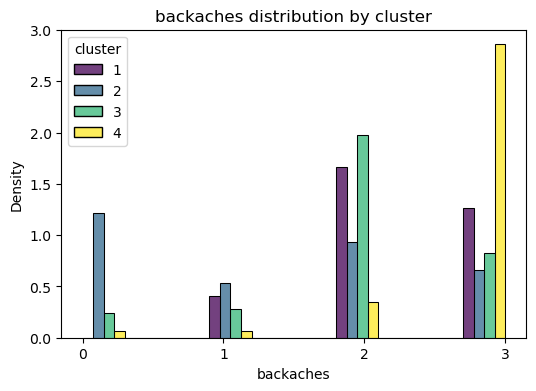


SIGNIFICANT difference in bodyaches levels between the clusters accoring to ANOVA.
                 sum_sq      df          F         PR(>F)
C(cluster)   883.089452     3.0  347.50284  3.980570e-180
Residual    1621.313572  1914.0        NaN            NaN


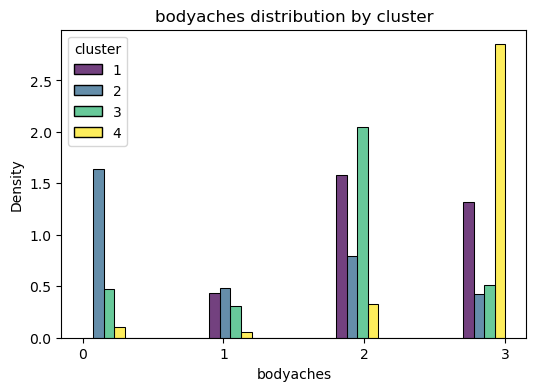


SIGNIFICANT difference in stomach_cramps levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   597.269494     3.0  223.076975  4.252581e-124
Residual    1708.190360  1914.0         NaN            NaN


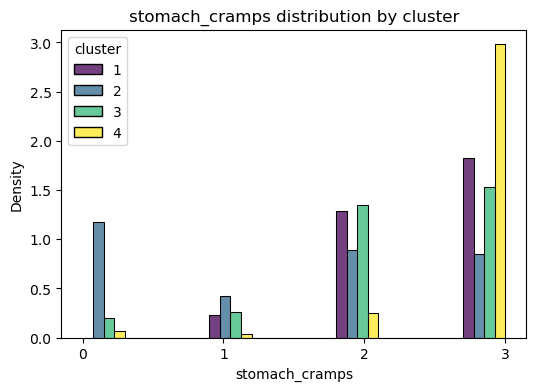


SIGNIFICANT difference in headache levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   726.227901     3.0  285.608708  3.389094e-153
Residual    1622.266364  1914.0         NaN            NaN


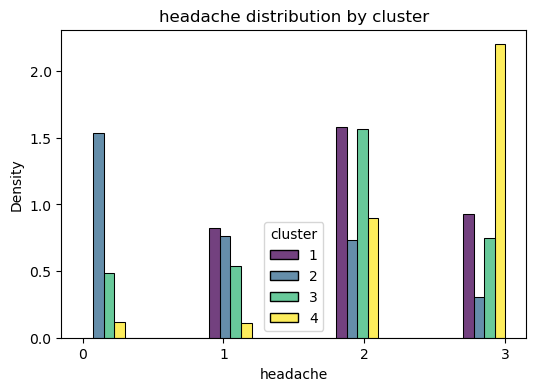


SIGNIFICANT difference in indigestion levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   531.332399     3.0  206.378692  5.689455e-116
Residual    1642.563326  1914.0         NaN            NaN


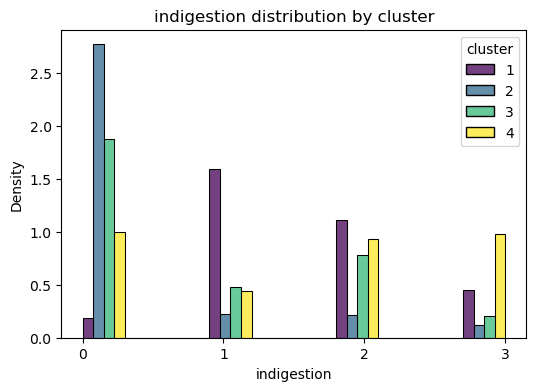


SIGNIFICANT difference in constipation levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   619.252238     3.0  207.136812  2.413657e-116
Residual    1907.352559  1914.0         NaN            NaN


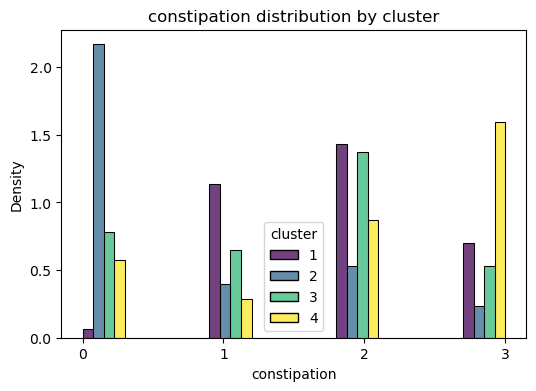


SIGNIFICANT difference in diarrhea levels between the clusters accoring to ANOVA.
                 sum_sq      df           F        PR(>F)
C(cluster)   407.906919     3.0  125.132548  5.209897e-74
Residual    2079.751580  1914.0         NaN           NaN


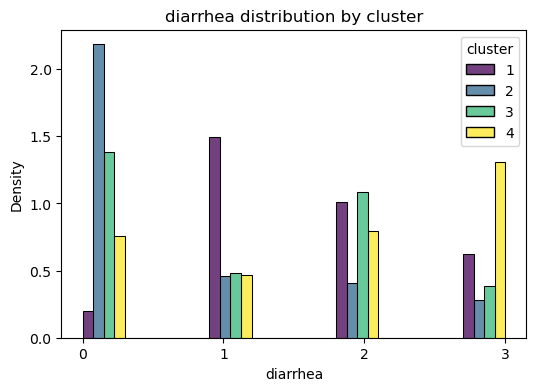


SIGNIFICANT difference in nausea levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   739.793345     3.0  273.834544  7.180133e-148
Residual    1723.625320  1914.0         NaN            NaN


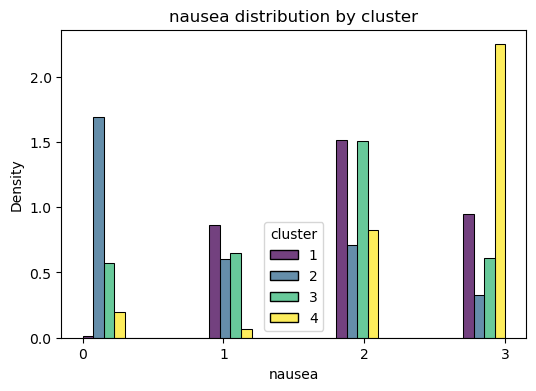


SIGNIFICANT difference in vomiting levels between the clusters accoring to ANOVA.
                sum_sq      df           F         PR(>F)
C(cluster)  370.643653     3.0  252.170082  6.878567e-138
Residual    937.742687  1914.0         NaN            NaN


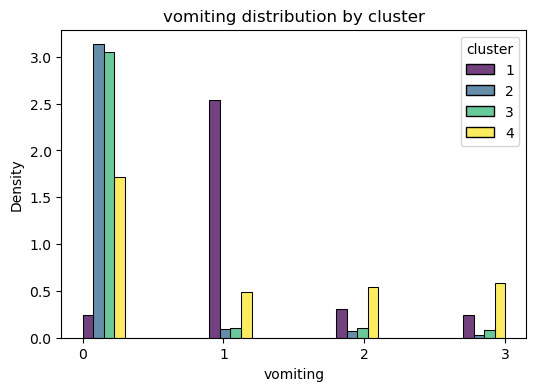


SIGNIFICANT difference in temperature levels between the clusters accoring to ANOVA.
                sum_sq      df         F        PR(>F)
C(cluster)   21.390281     3.0  22.40366  2.953781e-14
Residual    609.141523  1914.0       NaN           NaN


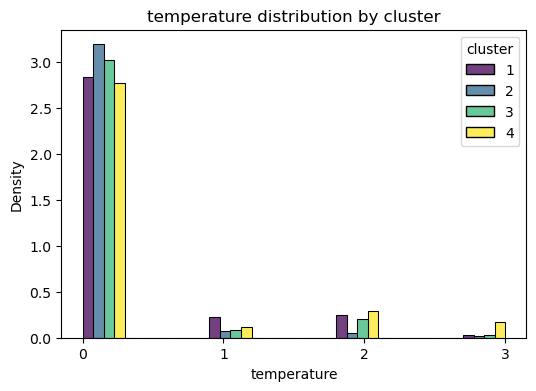


SIGNIFICANT difference in hot_flashes levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   842.226374     3.0  327.691834  1.075781e-171
Residual    1639.773626  1914.0         NaN            NaN


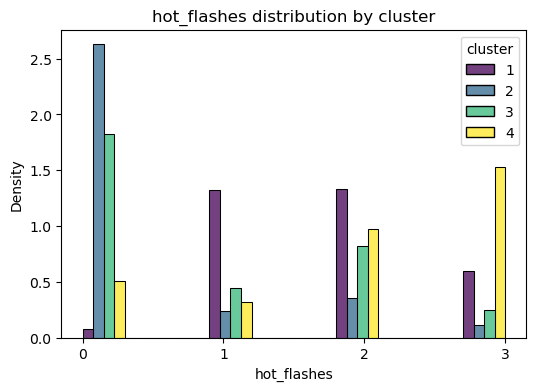


SIGNIFICANT difference in insomnia levels between the clusters accoring to ANOVA.
                 sum_sq      df           F         PR(>F)
C(cluster)   762.666742     3.0  242.961705  1.423892e-133
Residual    2002.708127  1914.0         NaN            NaN


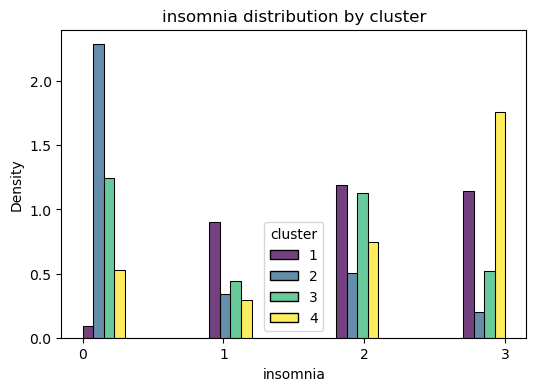


SIGNIFICANT difference in sleep levels between the clusters accoring to ANOVA.
                  sum_sq      df         F  PR(>F)
C(cluster)  1.651407e+04     3.0  2.809857  0.0382
Residual    3.749649e+06  1914.0       NaN     NaN


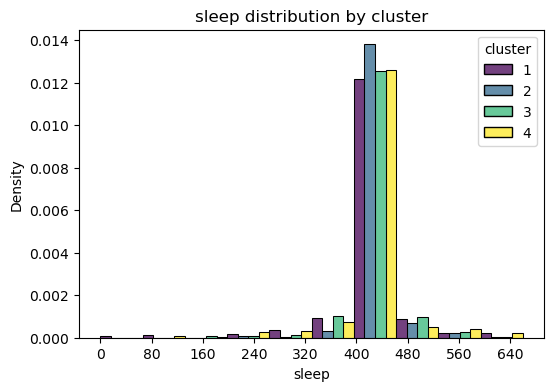


SIGNIFICANT difference in work_affected levels between the clusters accoring to ANOVA.
                sum_sq      df          F        PR(>F)
C(cluster)   38.008278     3.0  61.957229  3.154045e-38
Residual    391.387446  1914.0        NaN           NaN


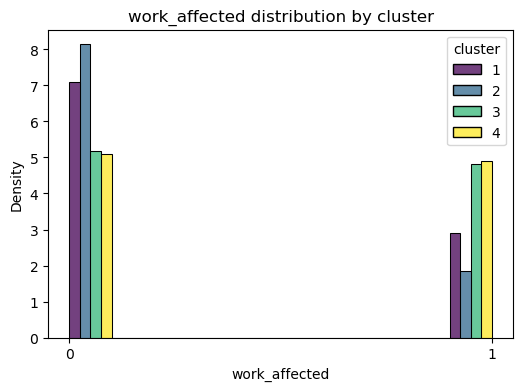

In [27]:
from matplotlib.ticker import MaxNLocator
# List of variables to plot
variables = ['pain_level', 'period_intensity', 'overall_pain', 'bloating', 'appetite_loss', 'tiredness', 'fever', 
             'log_steps', 'weight' ,'backaches','bodyaches', 'stomach_cramps', 'headache', 'indigestion', 'constipation',
             'diarrhea', 'nausea', 'vomiting', 'temperature', 'hot_flashes', 'insomnia', 'sleep', 'work_affected'] 

def plot_histogram_by_cluster(data, var):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=data, x=var, hue='cluster', palette='viridis', element='bars',
                 stat='density', common_norm=False, bins=10, multiple="dodge")    
    plt.title(f'{var} distribution by cluster')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig(f'fig/cluster_dist_{var}.png', dpi=300)
    plt.show()

sig_var =[]
    
# Create distribution plots and ANOVA for each variable of interest by cluster
for var in variables:

    # ANOVA
    anova_model = ols(f'{var} ~ C(cluster)', data=clustered_data).fit()
    anova_results = anova_lm(anova_model, typ=2)
    # Interpretation
    alpha = 0.05
    p_value = anova_results['PR(>F)']['C(cluster)']
    
    if p_value < alpha:
        print(f'\nSIGNIFICANT difference in {var} levels between the clusters accoring to ANOVA.')
        sig_var.append(var)
    else:
        print(f'\nNO significant difference in {var} levels between the clusters accoring to ANOVA.')

    print(anova_results)
    plot_histogram_by_cluster(clustered_data, var)


In [28]:
print(sig_var)
#clustered_data.columns

['pain_level', 'period_intensity', 'overall_pain', 'bloating', 'appetite_loss', 'tiredness', 'fever', 'log_steps', 'backaches', 'bodyaches', 'stomach_cramps', 'headache', 'indigestion', 'constipation', 'diarrhea', 'nausea', 'vomiting', 'temperature', 'hot_flashes', 'insomnia', 'sleep', 'work_affected']


In [29]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,weight,sleep,log_steps,cluster
0,1,1,4,0,3,2,3,3,3,3,...,1,0,2,2,1,1,85.53192,427.959908,8.954738,4
1,1,1,3,7,1,2,3,2,1,0,...,0,0,0,0,0,1,85.53192,427.959908,8.336683,3
2,1,0,3,9,3,3,3,3,2,3,...,2,3,3,2,3,0,85.53192,427.959908,8.336683,4
3,1,0,1,0,1,2,2,3,1,1,...,1,1,1,1,1,0,85.53192,427.959908,9.364491,1
4,1,1,6,0,1,2,2,2,2,2,...,0,0,1,0,1,1,85.53192,427.959908,8.336683,3


In [30]:
# Drop columns with less significance
clustered_short = clustered_data.drop(columns=['sleep', 'weight', 'sex', 'period'])
#clustered_short = clustered_data[['cluster','pain_level','backaches','tiredness']]

In [31]:
clustered_filled = clustered_short.fillna(0)
cluster_sum = clustered_filled.groupby('cluster').sum()
cluster_sum = cluster_sum.reset_index()
cluster_sum

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,headache,...,dizziness,pins_and_needles,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,log_steps
0,1,590,1890,558,560,612,468,430,96,502,...,454,343,59,295,428,356,320,498,72,2027.780095
1,2,1279,4411,1022,780,1115,367,403,285,736,...,438,136,55,95,301,172,139,458,145,6517.058166
2,3,1660,3581,1071,944,1200,616,657,288,941,...,628,233,90,146,450,303,227,679,256,4443.167649
3,4,1069,2859,1005,997,1021,829,700,279,917,...,797,497,128,364,739,505,412,762,176,3001.752428


In [32]:
# Normalise pain_level, weight, sleep, steps to a scale range
cluster_sum['pain_level'] = (cluster_sum['pain_level'] - cluster_sum['pain_level'].min()) / (cluster_sum['pain_level'].max() - cluster_sum['pain_level'].min()) * (1800 - 800) + 800
cluster_sum['log_steps'] = (cluster_sum['log_steps'] - cluster_sum['log_steps'].min()) / (cluster_sum['log_steps'].max() - cluster_sum['log_steps'].min()) * (1000 - 500) + 500
cluster_sum.head()

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,headache,...,dizziness,pins_and_needles,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,log_steps
0,1,590,800.000000,558,560,612,468,430,96,502,...,454,343,59,295,428,356,320,498,72,500.000000
1,2,1279,1800.000000,1022,780,1115,367,403,285,736,...,438,136,55,95,301,172,139,458,145,1000.000000
2,3,1660,1470.765569,1071,944,1200,616,657,288,941,...,628,233,90,146,450,303,227,679,256,769.017369
3,4,1069,1184.371281,1005,997,1021,829,700,279,917,...,797,497,128,364,739,505,412,762,176,608.477612


In [33]:
# Custom colours for grouped symptoms
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    color_mapping = {
        
        # Blues
        'sex': '#4682B4',
        'period': '#000080',
        'skin_changes': '#87CEFA',
        'weight': '#4169E1',
        'sleep': '#000080',
        'log_steps': '#4682B4',

        # Purples
        'tiredness':'#9370DB', 
        'dizziness':'#9932CC', 
        'pins_and_needles':'#4169E1',
        'insomnia':'#DA70D6',
        'hot_flashes': '#8A2BE2',
        'acne': '#9400D3',
        'skin_changes': '#9400D3',
        'fever': '#C9A0DC',
        'temperature': '#E6E6FA',
        'short_of_breath': '#B19CD9',
        'coughing': '#B19CD9',
        'work_affected':'#9932EC', 
        
        # Reds
        'pain_level': '#DC143C',
        'period_intensity': '#FF6347',
        'overall_pain':"#B22222",   
        'backaches': '#CD5C5C', 
        'bodyaches': '#FA8072',
        'stomach_cramps': '#E9967A' , 
        'joint_pains':'#FF7F50', 
        'tender_breasts': '#F08080', 
        'headache':"#B22222", 

        # Browns
        'indigestion':"#A0522D",
        'bloating':"#8B4513", 
        'constipation':'brown', 
        'diarrhea':'#D2691E',
        'nausea':'#F4A460', 
        'vomiting':'#E69F00', 
        'appetite_loss':'#BC8F8F', 
        'cravings_salty':"#B8860B", 
        'cravings_sweet': "#DEB887", 
        
    }
    return color_mapping.get(word, "black") 

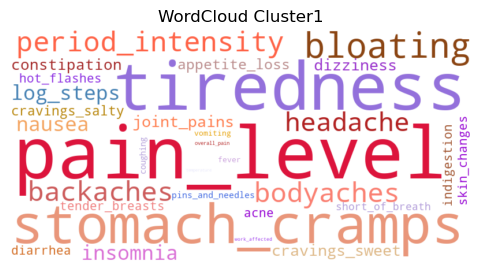

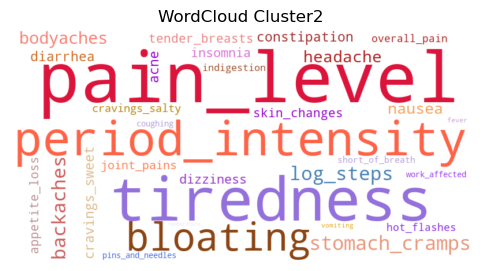

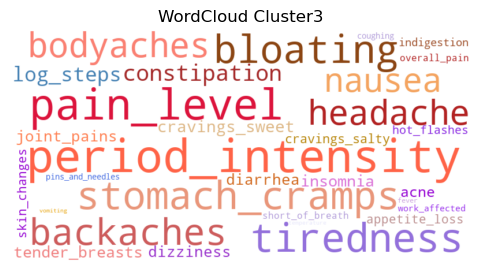

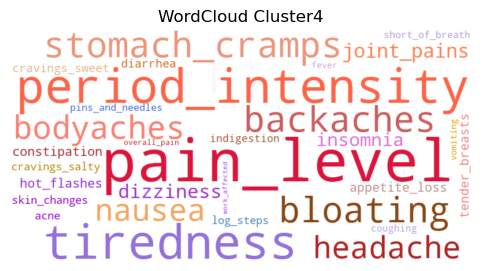

In [34]:
# Create WordCloud for each cluster
def create_wordcloud(row, title, var):
    # Dictionary with column names as words and values as frequencies
    col_value = row.to_dict()
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(col_value)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'fig/wordcloud_sum_{var}.png', dpi=300)  
    plt.show()

for index, row in cluster_sum.iterrows():
    create_wordcloud(row.drop('cluster'), title=f'WordCloud Cluster{round(row["cluster"])}', var=round(row["cluster"]))